# 1. Persistence

First, let's check your GUDHI version, version 3.9.0 (the latest) is recommended.

In [1]:
import gudhi as gd
print(gd.__version__)

3.9.0


In [2]:
# We will need a few other libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
# To get nice interactive plots. May require installing ipympl and restarting the kernel.
# Other possibilities than notebook include qt, osx, tk... If nothing works, just remove this line
#%matplotlib notebook

The documentation for the Python interface of Gudhi is [here](https://gudhi.inria.fr/python/latest/). There are also some [tutorials](https://github.com/GUDHI/TDA-tutorial), an [issue tracker](https://github.com/GUDHI/gudhi-devel/issues), a [mailing-list](https://sympa.inria.fr/sympa/arc/gudhi-users/), etc.

## Functions, cubical complex
### Volcano
Let us first define a function from $\mathbb{R}^2$ to $\mathbb{R}$.

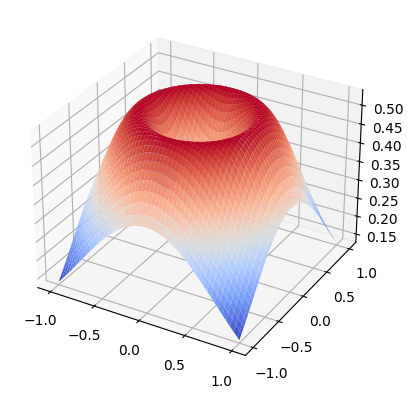

In [3]:
grid = np.linspace(-1,1,100)
gridx = grid[:,np.newaxis]
gridy = grid[np.newaxis,:]
sq = - gridx**2 - gridy**2
volcano = np.exp(sq) - 0.7 * np.exp(sq*4)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(gridx, gridy, volcano, cmap=matplotlib.cm.coolwarm)
plt.show()

Now we have a function, we can build a filtered [cubical complex](https://gudhi.inria.fr/python/latest/cubical_complex_ref.html) from it and compute the persistence diagram of its **sub**levelsets.

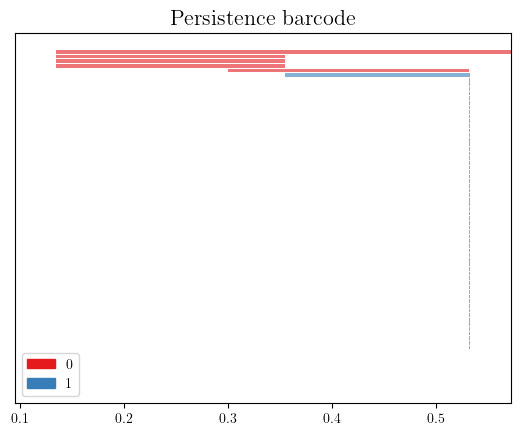

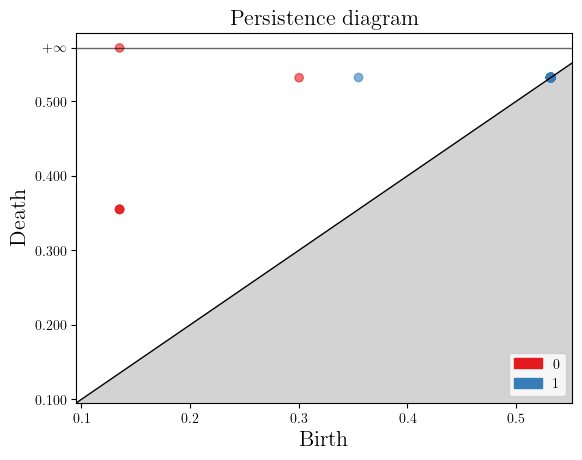

In [4]:
cplx = gd.CubicalComplex(top_dimensional_cells=volcano)
diag = cplx.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)
# red is dimension 0, blue is dimension 1
plt.show()

(The name top_dimensional_cells is because gudhi does the opposite of what we saw in class, it gives the grid values to top-dimensional cells and deduces values for other cells, instead of giving values to vertices and deducing values for other cells. The difference is not important here.)

Compare the 2 plots. Why do we only see 3 red points but 5 red bars? Why are more than 60 of the bars invisible? You can print `diag` to help, the format is a list of `(dimension, (birth, death))`.

 > **Answer:** 3 red bars are (almost) identical, so they show as a single red point with multiplicity 3. The invisible extra bars correspond to the blue point that is almost on the diagonal (so the bars are less than 1 pixel). The top of the volcano has many local maxima, and each generates a very short-lived hole.

Now compute the persistence diagram of the **super**levelsets of this function (hint: there is no direct function to that, only sublevelsets).

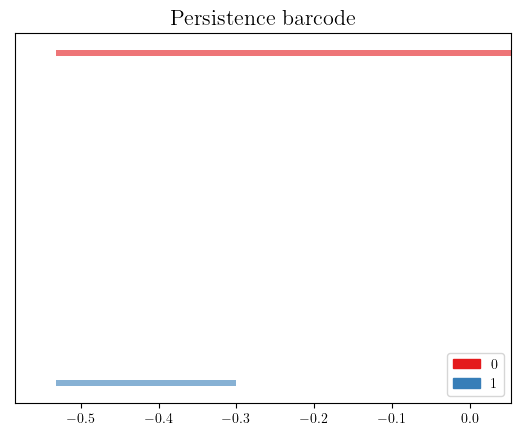

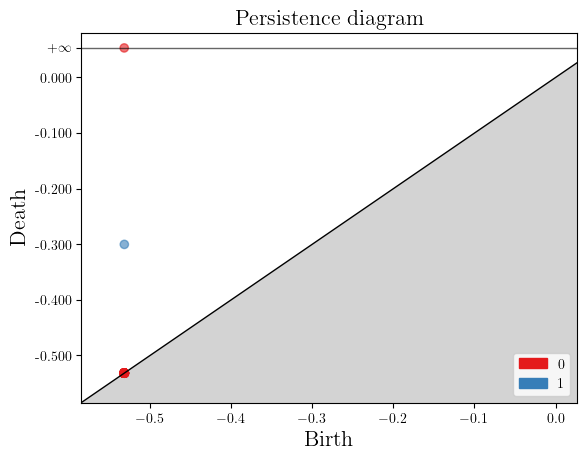

In [5]:
cplx2 = gd.CubicalComplex(top_dimensional_cells=-volcano)
diag2 = cplx2.persistence()
gd.plot_persistence_barcode(diag2)
gd.plot_persistence_diagram(diag2)
plt.show()

What happened to the point corresponding to the crater of the volcano between the sub- and super-levelsets?

 > **Answer:** It switched from a 0-dimensional feature (from below, we first have only the center, which is a connected component) to a 1-dimensional feature (from above, we are missing the center, that's a hole). There is some notion of duality between the two, although the hypotheses are not quite right for a true correspondence between the two diagrams.

### 1d function
In class, we looked at the function $f: t \mapsto sin(t)+sin(2t)$

Build a table with 200 values of f between 0 and $2\pi$. Plot the function, compute the persistence diagram of its sublevelsets, and draw its persistence diagram.

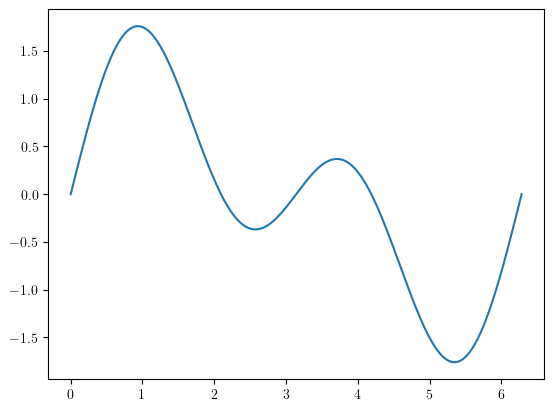

In [6]:
t = np.linspace(0, 2*np.pi, 200)
f = np.sin(t) + np.sin(2*t)
plt.figure()
plt.plot(t,f)
plt.show()

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

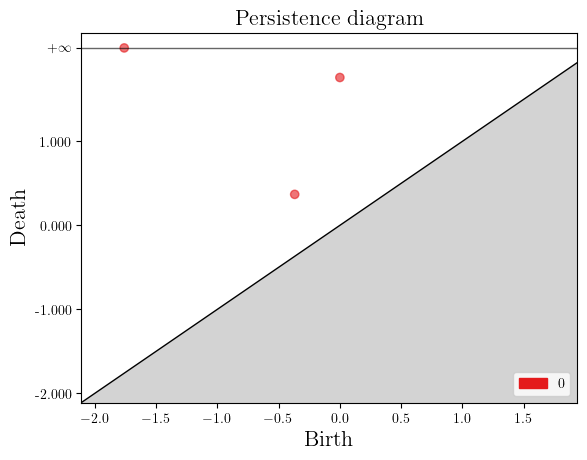

In [7]:
cplx = gd.CubicalComplex(top_dimensional_cells=f)
dgm = cplx.persistence()
gd.plot_persistence_diagram(dgm)

What happens if we consider a longer range instead of `[0, 2π]`?

We will reuse this function later.

 > **Answer:** `plot_persistence_barcode` shows several bars of same lifetime

<AxesSubplot:title={'center':'Persistence barcode'}>

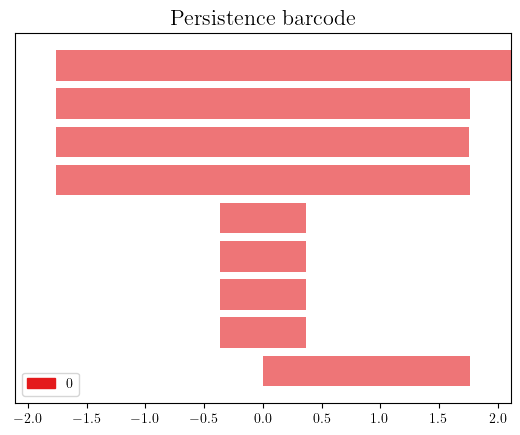

In [8]:
N = 4
t = np.linspace(0, N*2*np.pi, N*200)
f = np.sin(t) + np.sin(2*t)

dgm = gd.CubicalComplex(top_dimensional_cells=f).persistence()
gd.plot_persistence_barcode(dgm)

## Point sets
### Torus
As in the class, we first consider a set of points regularly spaced along a curve drawn on a torus. For simplicity, we embed this torus in $\mathbb{R}^4$.

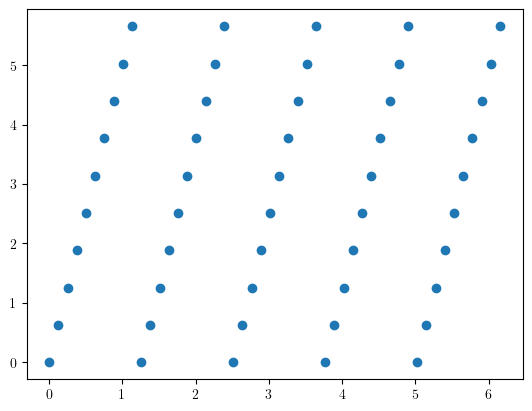

In [9]:
a = np.linspace(0, 2*np.pi, 50, False)
b = np.stack((np.cos(a),np.sin(a),np.cos(5*a),np.sin(5*a)),axis=-1)
# Plot the points on the unwrapped torus
plt.figure()
plt.scatter(a, 5*a % (2*np.pi))
plt.show()

We now compute the persistence of the Čech filtration of these points. We actually use an α-complex for that. Notice that the data-structure used to represent a simplicial complex in Gudhi is called SimplexTree.

[(3, (1.102595812673837, 2.0)), (2, (0.39373133684656436, 1.095491502812549)), (1, (0.09943415215528845, 1.10063495445449)), (1, (0.34549150281252605, 1.0)), (0, (0.0, inf))]


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

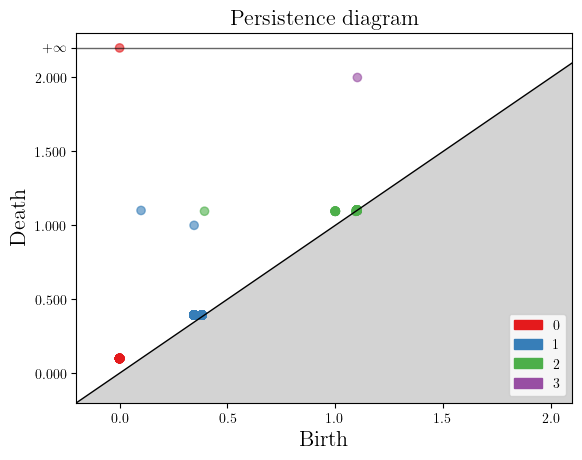

In [10]:
cplx = gd.AlphaComplex(points=b).create_simplex_tree()
p = cplx.persistence()
# print only the most persistent features
print([(dim,(birth,death)) for (dim,(birth,death)) in p if death - birth > .1])
gd.plot_persistence_diagram(p, legend=True)

Can you recognize the features of a torus here? Is there anything extra?

 > **Answer:** Among the persistent features, we see one connected component, two loops, and one 2d-hole, which corresponds to the topology of a torus. Notice that one of the loops appears significantly earlier than the other, and for a whole range of radii the union of balls centered on the points looks like a thick curve.

 > More surprising is the feature in dimension 3. We represented the torus as the product of the circles $x^2+y^2=1$ and $z^2+w^2=1$. This implies that all of our points lie on the 3-sphere $x^2+y^2+z^2+w^2=2$. They actually cover enough of this 3-sphere that its topology appears in the diagram.

Now try doing the same computation, but instead of using an α-complex we will approximate the Čech complex with a Rips complex ([doc](https://gudhi.inria.fr/python/latest/rips_complex_ref.html)). What happens if you only change the name of the class? While the α-complex naturally has the ambient dimension, the Rips complex may be built up to an arbitrary dimension, so you need to specify a `max_dimension`. Can you still see the 3-sphere? What happens if you specify a larger dimension, say `max_dimension=5`?

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

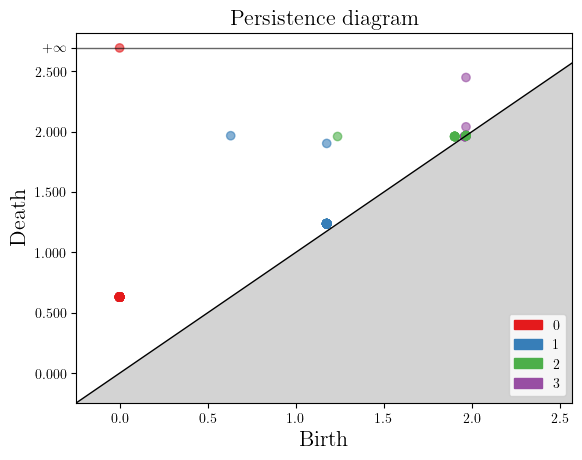

In [11]:
# Homology in dim p requires simplices in dim p+1
cplx = gd.RipsComplex(points=b).create_simplex_tree(max_dimension=4)
p = cplx.persistence()
gd.plot_persistence_diagram(p, legend=True)

With `max_dimension=5`, the program becomes quite slow and takes a lot more memory because the complex is very large. We could make it smaller by ignoring what happens for large radii (parameter `max_edge_length`), but in this case there are no interesting features in dimension 4, only noise.

Once the diagram has been computed with a call to [`persistence()`](https://gudhi.inria.fr/python/latest/simplex_tree_ref.html#gudhi.SimplexTree.persistence) (or just [`compute_persistence()`](https://gudhi.inria.fr/python/latest/simplex_tree_ref.html#gudhi.SimplexTree.compute_persistence) if you do not need the diagram in the form `persistence()` returns), you can get the points of the persistence diagram of dimension i as a convenient (n,2) numpy array:

In [12]:
cplx.persistence_intervals_in_dimension(1)

array([[1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.1755705 , 1.23709637],
       [1.

### Time series
Let us go back to the function $f$ define above. We saw in class that we can turn ([doc](https://gudhi.inria.fr/python/latest/point_cloud.html#time-delay-embedding)) it into a 2d point cloud with nice loops, so we try that.

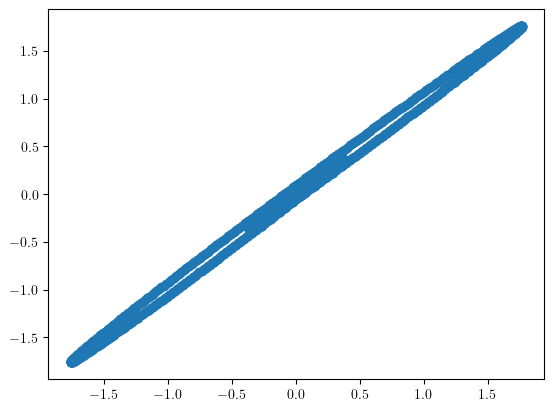

In [13]:
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
f2 = TimeDelayEmbedding(dim=2)(f)
plt.figure()
plt.scatter(f2[:,0],f2[:,1])
plt.show()

Hmm, those loops are way too squished to see anything. Can you fix it?

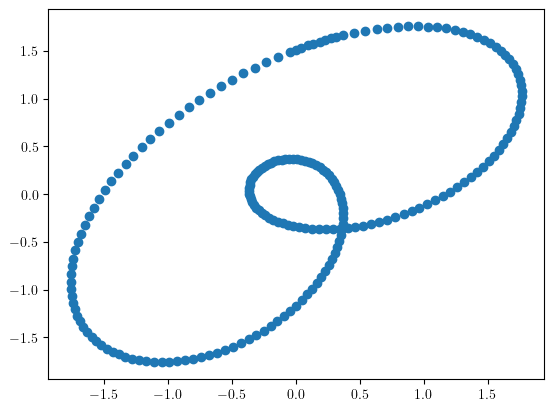

In [14]:
# Add extra points at the end so the lifted version does not have a hole
t = np.linspace(0, 7, 230)
f = np.sin(t) + np.sin(2*t)
# Add some delay
f2 = TimeDelayEmbedding(dim=2, delay=20)(f)
plt.figure()
plt.scatter(f2[:,0],f2[:,1])
plt.show()

Once the figure looks nice, compute or approximate the persistence diagram of the Čech filtration of this point set (here you have several choices). Dimension 1 seems the most relevant. Does the result have any connection with the diagram of the sublevelset computed at the beginning?

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

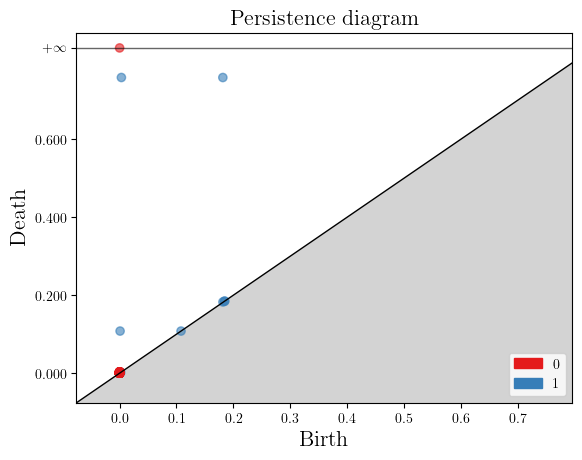

In [15]:
dgm = gd.AlphaComplex(points=f2).create_simplex_tree().persistence()
gd.plot_persistence_diagram(dgm)

 > **Answer:** We quickly get 2 loops, one for the small inner loop, and one for the whole curve. The inner loop is filled early. A bit later, the upper part joins the top of the small loop, which splits the large loops into two (this counts as one new loop). Eventually, they both get filled and disappear.

 > There does not seem to be any relation with the diagram of sublevelsets, they provide different information, and we cannot say a priori which one will be more relevant to a specific application.

## Distance and stability
### Point sets
Let us consider again the point set on a curve on a torus in $\mathbb{R}^4$, and compute the persistence diagram of dimension 1 of its Rips filtration. Now perturb each point randomly by a small noise, and compute the persistence diagram of dimension 1 of these new points. Compute the [bottleneck distance](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html#gudhi.bottleneck_distance) between these diagrams. Retry it a few times, maybe also with dimension 0 or 2. Can you confirm the stability result?

In [16]:
cplx = gd.RipsComplex(points=b).create_simplex_tree(2)
cplx.compute_persistence()
d1 = cplx.persistence_intervals_in_dimension(1)
# Generate random points in a small ball
epsilon = .001
l = []
while len(l) < len(b):
    pt = np.random.rand(4) * 2 - 1 # points in a square centered at origin
    if np.linalg.norm(pt) <= 1:
        l.append(pt) # Only keep the points in a ball of radius 1
noise = np.array(l) * epsilon
b_pert = b + noise
cplx_pert = gd.RipsComplex(points=b_pert).create_simplex_tree(2)
cplx_pert.compute_persistence()
d1_pert = cplx_pert.persistence_intervals_in_dimension(1)
print(gd.bottleneck_distance(d1, d1_pert))

0.0013595953615487266


 > **Answer:** The distance we get is larger than `epsilon`! But... smaller than `2*epsilon`. That's because Gudhi uses the diameter of simplices as filtration value for Rips complexes, instead of half of the diameter.

Now do the same experiment with the alpha-complex. Note that there is an even worse trap than for the Rips.

In [17]:
cplx = gd.AlphaComplex(points=b).create_simplex_tree()
cplx.compute_persistence()
d1a = cplx.persistence_intervals_in_dimension(1)
# Generate random points in a small ball
epsilon = .001
l = []
while len(l) < len(b):
    pt = np.random.rand(4) * 2 - 1 # points in a square centered at origin
    if np.linalg.norm(pt) <= 1:
        l.append(pt) # Only keep the points in a ball of radius 1
noise = np.array(l) * epsilon
b_pert = b + noise
cplx_pert = gd.AlphaComplex(points=b_pert).create_simplex_tree()
cplx_pert.compute_persistence()
d1a_pert = cplx_pert.persistence_intervals_in_dimension(1)
# AlphaComplex uses the square of distances, get back to true distances
d1a = np.sqrt(d1a)
d1a_pert = np.sqrt(d1a_pert)
print(gd.bottleneck_distance(d1a, d1a_pert))

0.0007621565174351641


 > **Answer:** The trap this time is that AlphaComplex uses square distances (if you are curious, this is because it also handles weights, which can make those values negative and would make the square root problematic).

In class, we said that Rips and Čech filtrations have close persistence diagrams in log-scale. Can you illustrate that on this dataset?

In [18]:
print(gd.bottleneck_distance(np.log(d1/2), np.log(d1a)), "is smaller than", np.log(2))

0.06505554970524599 is smaller than 0.6931471805599453


 > **Answer:** The distance is actually much smaller than the factor 2 in the interleaving (the inclusions between Rips and Čech) suggests.

### Functions
Similarly, illustrate the stability property on one of the functions seen above (either the volcano, or the curve).